In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage as ski
import scipy.signal as sig
from Bio import Align
from collections import Counter

# Global

In [10]:
degenerate_bases = {
    'R':['a','g'],
    'Y':['c','t'],
    'M':['a','c'],
    'K':['g','t'],
    'S':['g','c'],
    'W':['a','t'],
    'H':['a','t','c'],
    'B':['g','t','c'],
    'V':['g','a','c'],
    'D':['g','a','t'],
    'N':['a','c','t','g'],
    'A':['a'],
    'C':['c'],
    'T':['t'],
    'G':['g']
}
base_colors = {
    'a': plt.colormaps['Set2'](0),
    'c': plt.colormaps['Set2'](1),
    't': plt.colormaps['Set2'](2),
    'g': plt.colormaps['Set2'](3),
}

miss_color = '#0f59a4'
error_color = '#ed5a65'

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = ['Dejavu Sans Mono']

# Functions

In [18]:
def get_curves(file_name,base_info):
    image = ski.io.imread(f'{file_name}')
    height,width,depth = image.shape
    img = image[:,:,0]
    curves = pd.DataFrame()
    peak_high = 0
    for base in ['a','c','t','g']:
        start = end = base_info[base][0]
        lw = base_info[base][1]
        profile = ski.measure.profile_line(img, (height, start), (0, end),linewidth=lw,reduce_func=np.sum)
        curve = (profile.max() - profile) / 10 ** (len(str(profile.max()))-1)
        peak_high = len(str(profile.max()))-1
        curves[base] = curve
    return (curves,peak_high)

In [12]:
def base_calling(peaks):
    base_called = sig.find_peaks(peaks['signal'],distance=5,prominence=0.06)
    index = base_called[0]
    return index

In [13]:
def find_peaks(curves,threshold=0.5):
    signal = []
    bases_from = []
    for index, row in curves.iterrows():
        max_value = row.max()
        signal.append(max_value)
        bases = row[row >= (1-threshold)*max_value].index.tolist()
        base = [k for k, v in degenerate_bases.items() if sorted(v) == sorted(bases)]
        bases_from.append(base[0])
    #signal_smooth = sig.savgol_filter(signal, 5, 3, mode= 'nearest')
    peaks = pd.DataFrame({'signal':signal,'bases':bases_from})
    return peaks

In [14]:
def align_seq(target,query):
    aligner = Align.PairwiseAligner(match_score=1.0)
    aligner.mode = "local"
    aligner.match_score = 1
    aligner.open_gap_score = -1
    aligner.mismatch_score = -1
    aligner.extend_gap_score = -1
    alignments = aligner.align(target,query)
    alignment = alignments[0]
    coor = alignment.coordinates
    q_start = coor[1][0]
    q_end = coor[1][-1]
    counter = Counter(coor[1])
    max_value = 2
    target = alignment[0]
    stop = [key for key, value in counter.items() if value == max_value]
    #print(alignment)
    #print(coor)
    return (q_start,q_end,stop,target)

In [15]:
def format_seq(index,target,query,q_start,q_end,stop):
    res = []
    tick = []
    err = []
    miss = []
    #print(target)
    for i in range(q_start,q_end):
        base = query[i]
        tick.append(index[i])
        res.append(base)
        if i+1 in stop:
            #print(i,stop,len(query),len(index))
            tick.append(int((index[i] + index[i+1]) / 2))
            res.append('-')
    count = 0
    for i in range(len(res)):
        base = res[i]
        if count >= len(target):
            con = '-'
            miss.append(i)
        else:
            con = target[count]
            if con == '-' or base == '-':
                miss.append(i)
            elif con != base:
                err.append(i)
        count += 1
        res[i] = f'{base}\n{con}'
    tick.insert(0,-100)
    res.insert(0,'Consensus\nRef')
    return (res,tick,err,miss)

In [16]:
def plot(file_name,base_info,ref,title,threshold=0.1):
    fig,ax = plt.subplots(figsize=(8,1.5),dpi=300)
    curves,peak_high = get_curves(file_name,base_info)
    for base in ['a','c','t','g']:
        ax.plot(curves[base],label = f'{base.upper()}',color=base_colors[base])
    peaks = find_peaks(curves,threshold)
    index = base_calling(peaks)
    #ax.plot(index,peaks['signal'][index],'o',markersize=4,color='red')
    seq_q = ''.join(peaks['bases'][index].tolist())
    q_start,q_end,stop,target = align_seq(ref,seq_q)
    res,tick,err,miss = format_seq(index,target,seq_q,q_start,q_end,stop)
    ax.set_xticks(ticks=tick)
    ax.set_xticklabels(labels=res,fontsize=7)
    current_labels = ax.get_xticklabels()
    new_labels = list(current_labels)
    for m in miss:
        new_labels[m+1].set_color(miss_color)
        new_labels[m+1].set_fontweight('bold')
    for e in err:
        new_labels[e+1].set_color(error_color)
        new_labels[e+1].set_fontweight('bold')
    ax.set_xlabel('')
    ax.set_ylabel(f'Intensity($10^{peak_high}$)',fontsize=9)
    ax.set_title(f'{title}',size=10)
    base_legend = []
    for base in base_colors.keys():
        base_legend.append(mpl.patches.Rectangle((1, 1), width=2, height=3, color=base_colors[base], label=f'{base.upper()}'))
    fig.tight_layout()
    fig.legend(title='Bases',bbox_to_anchor=(1.1,1),loc='upper right',handles=base_legend,fontsize=6,   prop={'size': 8})

# Test

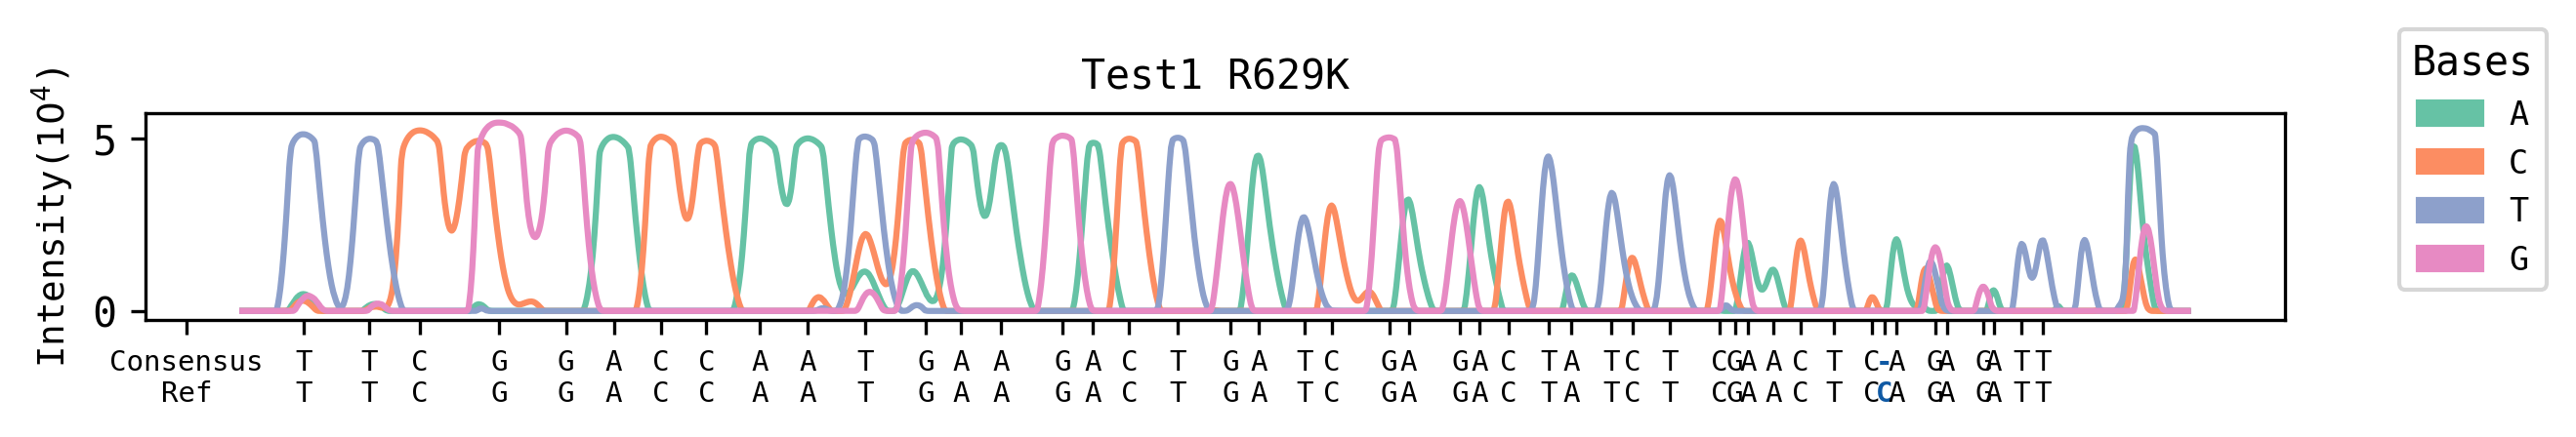

In [21]:
file_name = './test1.tif'
base_info = {'a':(204,250),'c':(503,250),'t':(801,250),'g':(1100,250)}
ref = 'TTCGGACCAATGAAGACTGATCGAGACTATCTCGAACTCCAGAGATTATC'
title = 'Test1 R629K'
threshold = 0.1
plot(file_name,base_info,ref,title)